# Group B2

# Prelude: Building the Network

Contains the following:
1. Imports and defining helper functions
2. Scraping data from wikipedia and downloads it
3. Building the network either from
    - (A) Downloaded files
    - (B) Local pickle file (created from last time A was run)
4. Simple prelimenary data analysis of network

In [6]:
import shutil
import pickle
import networkx as nx
import os
from utils_wiki import getJsonResponse, findLinks, build_graph_from_files
from utils_globals import *
if not os.path.exists(PICKLE_DIR):
		os.makedirs(PICKLE_DIR)

unwanted_list = ["List_of_philosophers", "Philosopher", "Stanford_Encyclopedia_of_Philosophy", "Encyclopedia_of_Philosophy", "Routledge_Encyclopedia_of_Philosophy", "The_Cambridge_Dictionary_of_Philosophy", "The_Oxford_Companion_to_Philosophy", "Philosophy"]

## 2. Scraping data
Fetches philosopher data from their wikipedia pages and downloads the wikipedia pages as `{philosopher_name}.txt` in a `downloads/` directory.

>**NOTES**
> 1. This takes a while to run
> 2. It deletes all previous content in `downloads`
> 3. Downloads all pages but skips pages with *no content* or *redirects*.

In [ ]:
wiki_links = ["List of philosophers (A–C)", "List of philosophers (D–H)", "List of philosophers (I–Q)", "List of philosophers (R–Z)"]
title_links = []

verbose = False # Debug output during loops
invalid_links = []  # Track titles that could not be saved
redirect_links = []  # Track titles that are redirects

# Delete and recreate the downloads directory
if os.path.exists(DOWNLOADS_DIR):
	shutil.rmtree(DOWNLOADS_DIR)  # Delete the directory and all its contents
os.makedirs(DOWNLOADS_DIR, exist_ok=True)  # Recreate the directory


for wiki_link in wiki_links:
  wiki_markup = getJsonResponse(wiki_link)
  title_links.extend(findLinks(wiki_markup))

# Remove irrelevant links if they exist
for unwanted in unwanted_list:
	if unwanted in title_links:
		title_links.remove(unwanted)

# Writing to files (warning this takes a while)
for title_link in title_links:
	all_wikitext = getJsonResponse(title_link)
	if not all_wikitext:
		if verbose: print(f"Skipping '{title_link}' as it has no content.")
		invalid_links.append(title_link)  # Track invalid pages without modifying the list directly
		continue
  
  # Skip if the content starts with #REDIRECT
	if all_wikitext.strip().startswith("#REDIRECT"):
		if verbose: print(f"Skipping '{title_link}' as it is a redirect.")
		redirect_links.append(title_link)  # Track redirect pages
		continue
  
	filename = os.path.join(DOWNLOADS_DIR, f"{title_link}.txt")
	with open(filename, "w", encoding="utf-8") as file:
		file.write(all_wikitext) # save all the wikitext into one file

title_links = [link for link in title_links if link not in invalid_links + redirect_links]
print(f"Downloaded {len(title_links)} pages.")
print(f"Skipped {len(invalid_links)} pages with no content.")
print(f"Skipped {len(redirect_links)} redirect pages.")

Downloaded 1485 pages.
Skipped 32 pages with no content.
Skipped 249 redirect pages.


## 3. Building the network 

- (A) Create from scratch 
From `downloads/`directory (saves local pickle file for later)

In [2]:
S = build_graph_from_files(DOWNLOADS_DIR)
S.remove_nodes_from(unwanted_list)
pickle.dump(S, open(PICKLE_DIR + "/graph.pkl", "wb")) # Saved as local version for later use for (B)

S_undirected = S.to_undirected()
# Identify self-loop edges
self_loops = list(nx.selfloop_edges(S_undirected))

# Print nodes with self-loops
print(f"Nodes with self-loops: {[edge[0] for edge in self_loops]}")

# Remove self-loops
S_undirected.remove_edges_from(self_loops)
pickle.dump(S_undirected, open(PICKLE_DIR + "/graph_undirected.pkl", "wb")) # Saved as local version for later use for (B)

Nodes with self-loops: ['Pierre_Teilhard_de_Chardin', 'Shen_Buhai', 'Otto_Rühle', 'Plato']


- (B) OR use local version 
From `pickle` file created last time you ran (A)

In [3]:
# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

## 4. Prelimenary data analysis

In [4]:
print(f"Number of nodes in S: {S.number_of_nodes()}")
print(f"Number of edges in S: {S.number_of_edges()}, and in S_undirected: {S_undirected.number_of_edges()}")

# Calculating total data size
download_size = sum(os.path.getsize(os.path.join(DOWNLOADS_DIR, f)) for f in os.listdir(DOWNLOADS_DIR) if f.endswith(".txt"))
download_size_mb = download_size / (1024 * 1024)  # Convert bytes to MB
print(f"Size of downloaded data: {download_size_mb:.2f} MB")

Number of nodes in S: 1362
Number of edges in S: 10724, and in S_undirected: 8887
Size of downloaded data: 48.87 MB


# Communities

In [7]:
import pickle
import os
import re
from utils_wiki import get_category_data
from utils_network import filter_graph_by_attribute, count_nodes_by_attribute
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

## Extraction using `subfields` and `tradition`

### (A) Extracting `subfield`
From https://en.wikipedia.org/wiki/Lists_of_philosophers

#### (A.1) Fetching data
Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

In [8]:
subfield_links = [
		"List of aestheticians",
		"List of critical theorists",
		"List of environmental philosophers",
		"List of epistemologists",
		"List of ethicists",
		"List of existentialists",
		"List of feminist philosophers",
		"List of secular humanists", #List of Humanists redirect
		"List of logicians",
		"List of metaphysicians",
		"Index of sociopolitical thinkers", #List of Social and Political Philosophers redirect
		"List of phenomenologists",
		"List of philosophers of language",
		"List of philosophers of mind",
		"List of philosophers of religion",
		"List of philosophers of science",
		"List of political philosophers",
		"List of political theorists",
		"List of rationalists",
		"List of utilitarians"
]

##### -> `Option 1`: **Fetch the data from Wikipedia** (takes around 5 seconds)

In [9]:
replace_terms_subfields = [("List of", ""), ("Index of", "")]
clean_subfield_data, philosopher_subfield_info = get_category_data(
    subfield_links, replace_terms_subfields, verbose=True
)
pickle.dump(philosopher_subfield_info, open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "wb")) # Saved as local version for later use

print("Total =", len(philosopher_subfield_info))

- aestheticians: 86
- critical theorists: 107
- environmental philosophers: 80
- epistemologists: 122
- ethicists: 286
- existentialists: 60
- feminist philosophers: 134
- secular humanists: 413
- logicians: 291
- metaphysicians: 185
- sociopolitical thinkers: 245
- phenomenologists: 24
- philosophers of language: 141
- philosophers of mind: 140
- philosophers of religion: 110
- philosophers of science: 111
- political philosophers: 199
- political theorists: 137
- rationalists: 28
- utilitarians: 104
Total = 2183


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [10]:
philosopher_subfield_info = pickle.load(open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "rb"))

#### (A.2) Creating `S.subfields` network

In [11]:
S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)


Did not find subfields for: 768 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Antonin_Scalia', 'Johannes_Clauberg', 'Alexander_Neckam']
Original graph: 1362 nodes and 8887 edges
Filtered 'subfields' graph: 594 nodes and 4220 edges
--------------------------------------------------
Number of nodes by subfields:
 -> epistemologists: 78
 -> metaphysicians: 119
 -> philosophers of mind: 57
 -> critical theorists: 41
 -> ethicists: 115
 -> sociopolitical thinkers: 131
 -> political philosophers: 135
 -> political theorists: 73
 -> utilitarians: 29
 -> environmental philosophers: 8
 -> logicians: 89
 -> secular humanists: 34
 -> philosophers of religion: 49
 -> rationalists: 17
 -> aestheticians: 51
 -> philosophers of language: 68
 -> feminist philosophers: 22
 -> philosophers of science: 45
 -> phenomenologists: 11
 -> existentialists: 7
--------------------------------------------------


### (B) Using `tradition` (western/eastern divide)

#### (B.1) Extracting information from wikipedia

Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

##### -> `Option 1`: Extract from wikipedia

In [12]:
tradition_links = [
	"Timeline of Eastern philosophers",
	"Timeline of Western philosophers"
]

replace_terms_traditions = [("Timeline of", "")]
clean_tradition_data, philosopher_tradition_info = get_category_data(
    tradition_links, replace_terms_traditions, verbose=True
)
pickle.dump(philosopher_tradition_info, open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "wb")) # Saved as local version for later use
print("Total =", len(philosopher_tradition_info))

- Eastern philosophers: 343
- Western philosophers: 565
Total = 893


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [13]:
philosopher_tradition_info = pickle.load(open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "rb"))

#### (B.2) Creating `S_tradition` network

In [14]:
S_tradition = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_tradition_info,
    attribute_name='tradition',
    verbose=True
)

print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Did not find tradition for: 1016 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Antonin_Scalia', 'Peter_Unger', 'Johannes_Clauberg']
Original graph: 1362 nodes and 8887 edges
Filtered 'tradition' graph: 346 nodes and 2561 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 69
--------------------------------------------------


## Partitioning

### Imports and definitions

In [15]:
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

def create_partition_using_attribute(graph, attribute_name):
	partition = {}
	for node, data in graph.nodes(data=True):
		attribute = data.get(attribute_name)
		if isinstance(attribute, list):
			attribute = attribute[0]
		if attribute is not None:
				partition[node] = attribute
	return partition

def get_louvain_modularity(graph, partition_dict):
	return f"{community_louvain.modularity(partition_dict, graph):.4f}"

def plot_partition_heatmap(graph, attribute_partition, louvain_partition, attribute_name, top_n=7, title="Confusion Matrix"):
    """
    Plots a confusion matrix heatmap comparing attribute-based partition and Louvain community partition.

    Args:
        graph (networkx.Graph): The graph to analyze.
        attribute_partition (dict): Partition mapping nodes to their attributes.
        louvain_partition (dict): Louvain partition mapping nodes to communities.
        attribute_name (str): Name of the attribute (e.g., 'subfields' or 'tradition').
        top_n (int): Number of top attributes and communities to consider for the heatmap.
        title (str): Title of the heatmap.
    """
    # Step 1: Identify top attributes and communities
    attribute_counts = Counter(attribute_partition.values())
    top_attributes = [attribute for attribute, _ in attribute_counts.most_common(top_n)]

    community_counts = Counter(louvain_partition.values())
    top_communities = [community for community, _ in community_counts.most_common(top_n)]

    # Step 2: Map attributes and communities to matrix indices
    attribute_to_index = {attribute: idx for idx, attribute in enumerate(top_attributes)}
    community_to_index = {community: idx for idx, community in enumerate(top_communities)}

    # Step 3: Initialize confusion matrix D
    D = np.zeros((len(top_attributes), top_n), dtype=int)

    # Step 4: Populate the confusion matrix
    for node in graph.nodes:
        attribute = attribute_partition.get(node)  # Get node's attribute
        community = louvain_partition.get(node)  # Get node's Louvain community

        # Only consider top attributes and communities
        if community in community_to_index and attribute in attribute_to_index:
            i = attribute_to_index[attribute]
            j = community_to_index[community]
            D[i, j] += 1

    # Step 5: Create the heatmap
    plt.figure(figsize=(7, 7))
    plt.imshow(D, interpolation='nearest', cmap='Blues')

    # Add text annotations for each cell
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            plt.text(j, i, int(D[i, j]), ha="center", va="center", color="black")

    # Add titles, labels, and ticks
    plt.title(title)
    plt.xlabel('Communities')
    plt.ylabel(f'{attribute_name.capitalize()}')

    # Set tick labels
    plt.xticks(np.arange(len(top_communities)), [f"C {c}" for c in top_communities])
    plt.yticks(np.arange(len(top_attributes)), top_attributes)

    # Add a color bar
    plt.colorbar()
    plt.show()

### (A) Partitioning using `S_subfields`

Each node is characterized by the first `subfield` if there are multiple.

In [16]:
subfields_partition = create_partition_using_attribute(S_subfields, 'subfields')
subfields_partition_modularity = get_louvain_modularity(S_subfields, subfields_partition)
print("Subfields partion Modularity = ", subfields_partition_modularity)

louvain_partition_S_subfields = community_louvain.best_partition(S_subfields, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields))

# louvain_partition_S_subfields_kmeans = louvain_kmeans_partition(S_subfields, len(subfield_links))
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields_kmeans))

Subfields partion Modularity =  0.0872
Louvain partion Modularity =  0.4295


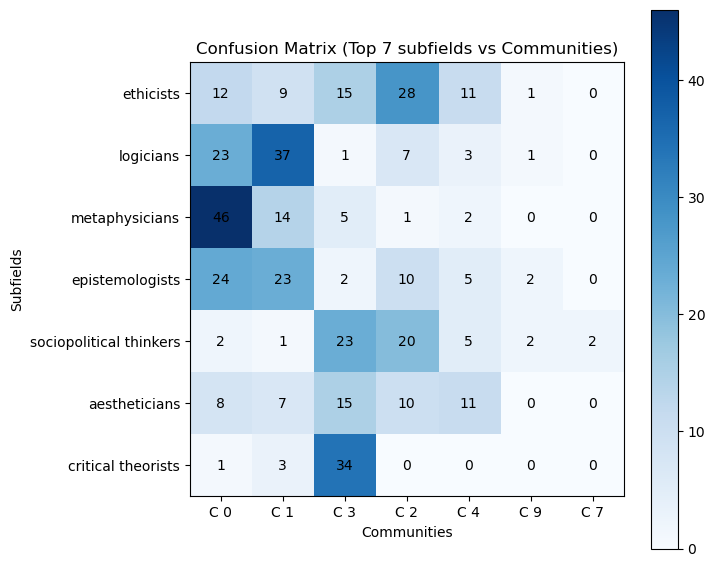

In [17]:
plot_partition_heatmap(
    graph=S_subfields,
    attribute_partition=subfields_partition,
    louvain_partition=louvain_partition_S_subfields,
    attribute_name='subfields',
    title='Confusion Matrix (Top 7 subfields vs Communities)'
)

### (B) Partitioning using `S_tradition`

In [18]:
tradition_partition = create_partition_using_attribute(S_tradition, 'tradition')
tradition_partition_modularity = get_louvain_modularity(S_tradition, tradition_partition)

print("Tradition partion Modularity = ", tradition_partition_modularity)

louvain_partition_S_tradition = community_louvain.best_partition(S_tradition, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition))

# louvain_partition_S_tradition_kmeans = louvain_kmeans_partition(S_tradition, 2)
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition_kmeans))

Tradition partion Modularity =  0.0802
Louvain partion Modularity =  0.3946


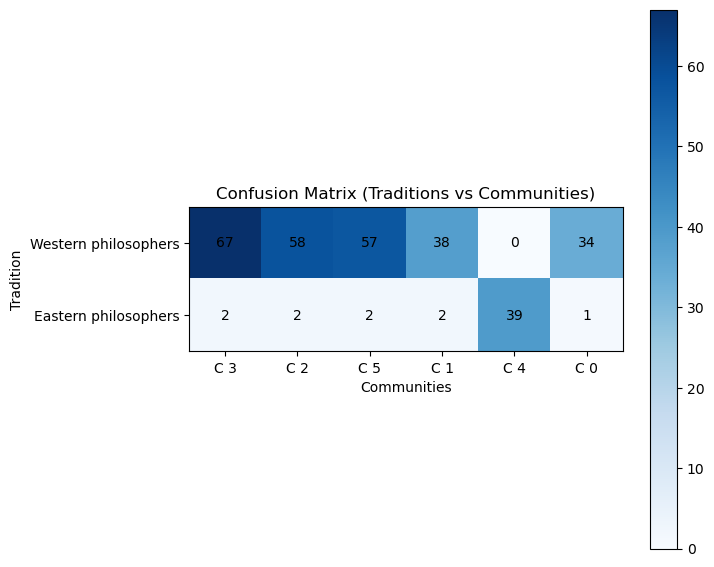

In [19]:
plot_partition_heatmap(
    graph=S_tradition,
    attribute_partition=tradition_partition,
    louvain_partition=louvain_partition_S_tradition,
    attribute_name='tradition',
    top_n=6,
	title='Confusion Matrix (Traditions vs Communities)'
)

# TF-IDF Word Clouds

In [20]:
import pickle
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from utils_sentiment_tfidf import *
from utils_globals import *

In [21]:
# Load the partition
subfields_partition = pickle.load(open(PICKLE_DIR + "/subfields_partition.pkl", "rb"))
tradition_partition = pickle.load(open(PICKLE_DIR + "/tradition_partition.pkl", "rb"))

In [22]:
philosopher_names = set()

for filename in os.listdir(DOWNLOADS_DIR):
    if filename.endswith(".txt"):
        philosopher = filename.replace(".txt", "").replace("_", " ").lower() # Ensure lowercase
        philosopher_names.update(philosopher.split())

In [23]:
# Load partition and generate cleaned texts
subfield_texts = compile_and_clean_all_subfields(subfields_partition, DOWNLOADS_DIR)
print(f"Compiled and cleaned text for {len(subfield_texts)} subfields.")

tradition_texts = compile_and_clean_all_subfields(tradition_partition, DOWNLOADS_DIR)
print(f"Compiled and cleaned text for {len(tradition_texts)} subfields.")

Compiled and cleaned text for 19 subfields.
Compiled and cleaned text for 2 subfields.


Process text and count words.

In [24]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [25]:
# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
additional_exclusions = {
    'bc', 'ad', 'etc', 'philosophy', 'philosophical', 'thought', 'life', 'human',
    'idea', 'wrote', 'first', 'would', 'also', 'one', 'two', 'three', 'four',
    'ancient', 'medieval', 'modern', 'english', 'french', 'german'
}
excluded_words = philosopher_names.union(additional_exclusions)

In [26]:
# Process text and count word frequencies for all subfields
word_counts_by_subfield = {}
word_counts_by_tradition = {}

for subfield, text in subfield_texts.items():
    word_counts_by_subfield[subfield] = process_text(text, stop_words, lemmatizer, excluded_words)

for tradition, text in tradition_texts.items():
    word_counts_by_tradition[tradition] = process_text(text, stop_words, lemmatizer, excluded_words)

In [27]:
# Compute TF-IDF for all subfields
tf_idf_scores = compute_tf_idf(word_counts_by_subfield)
tf_idf_scores_traditions = compute_tf_idf(word_counts_by_tradition)

### Word Clouds by `subfield`

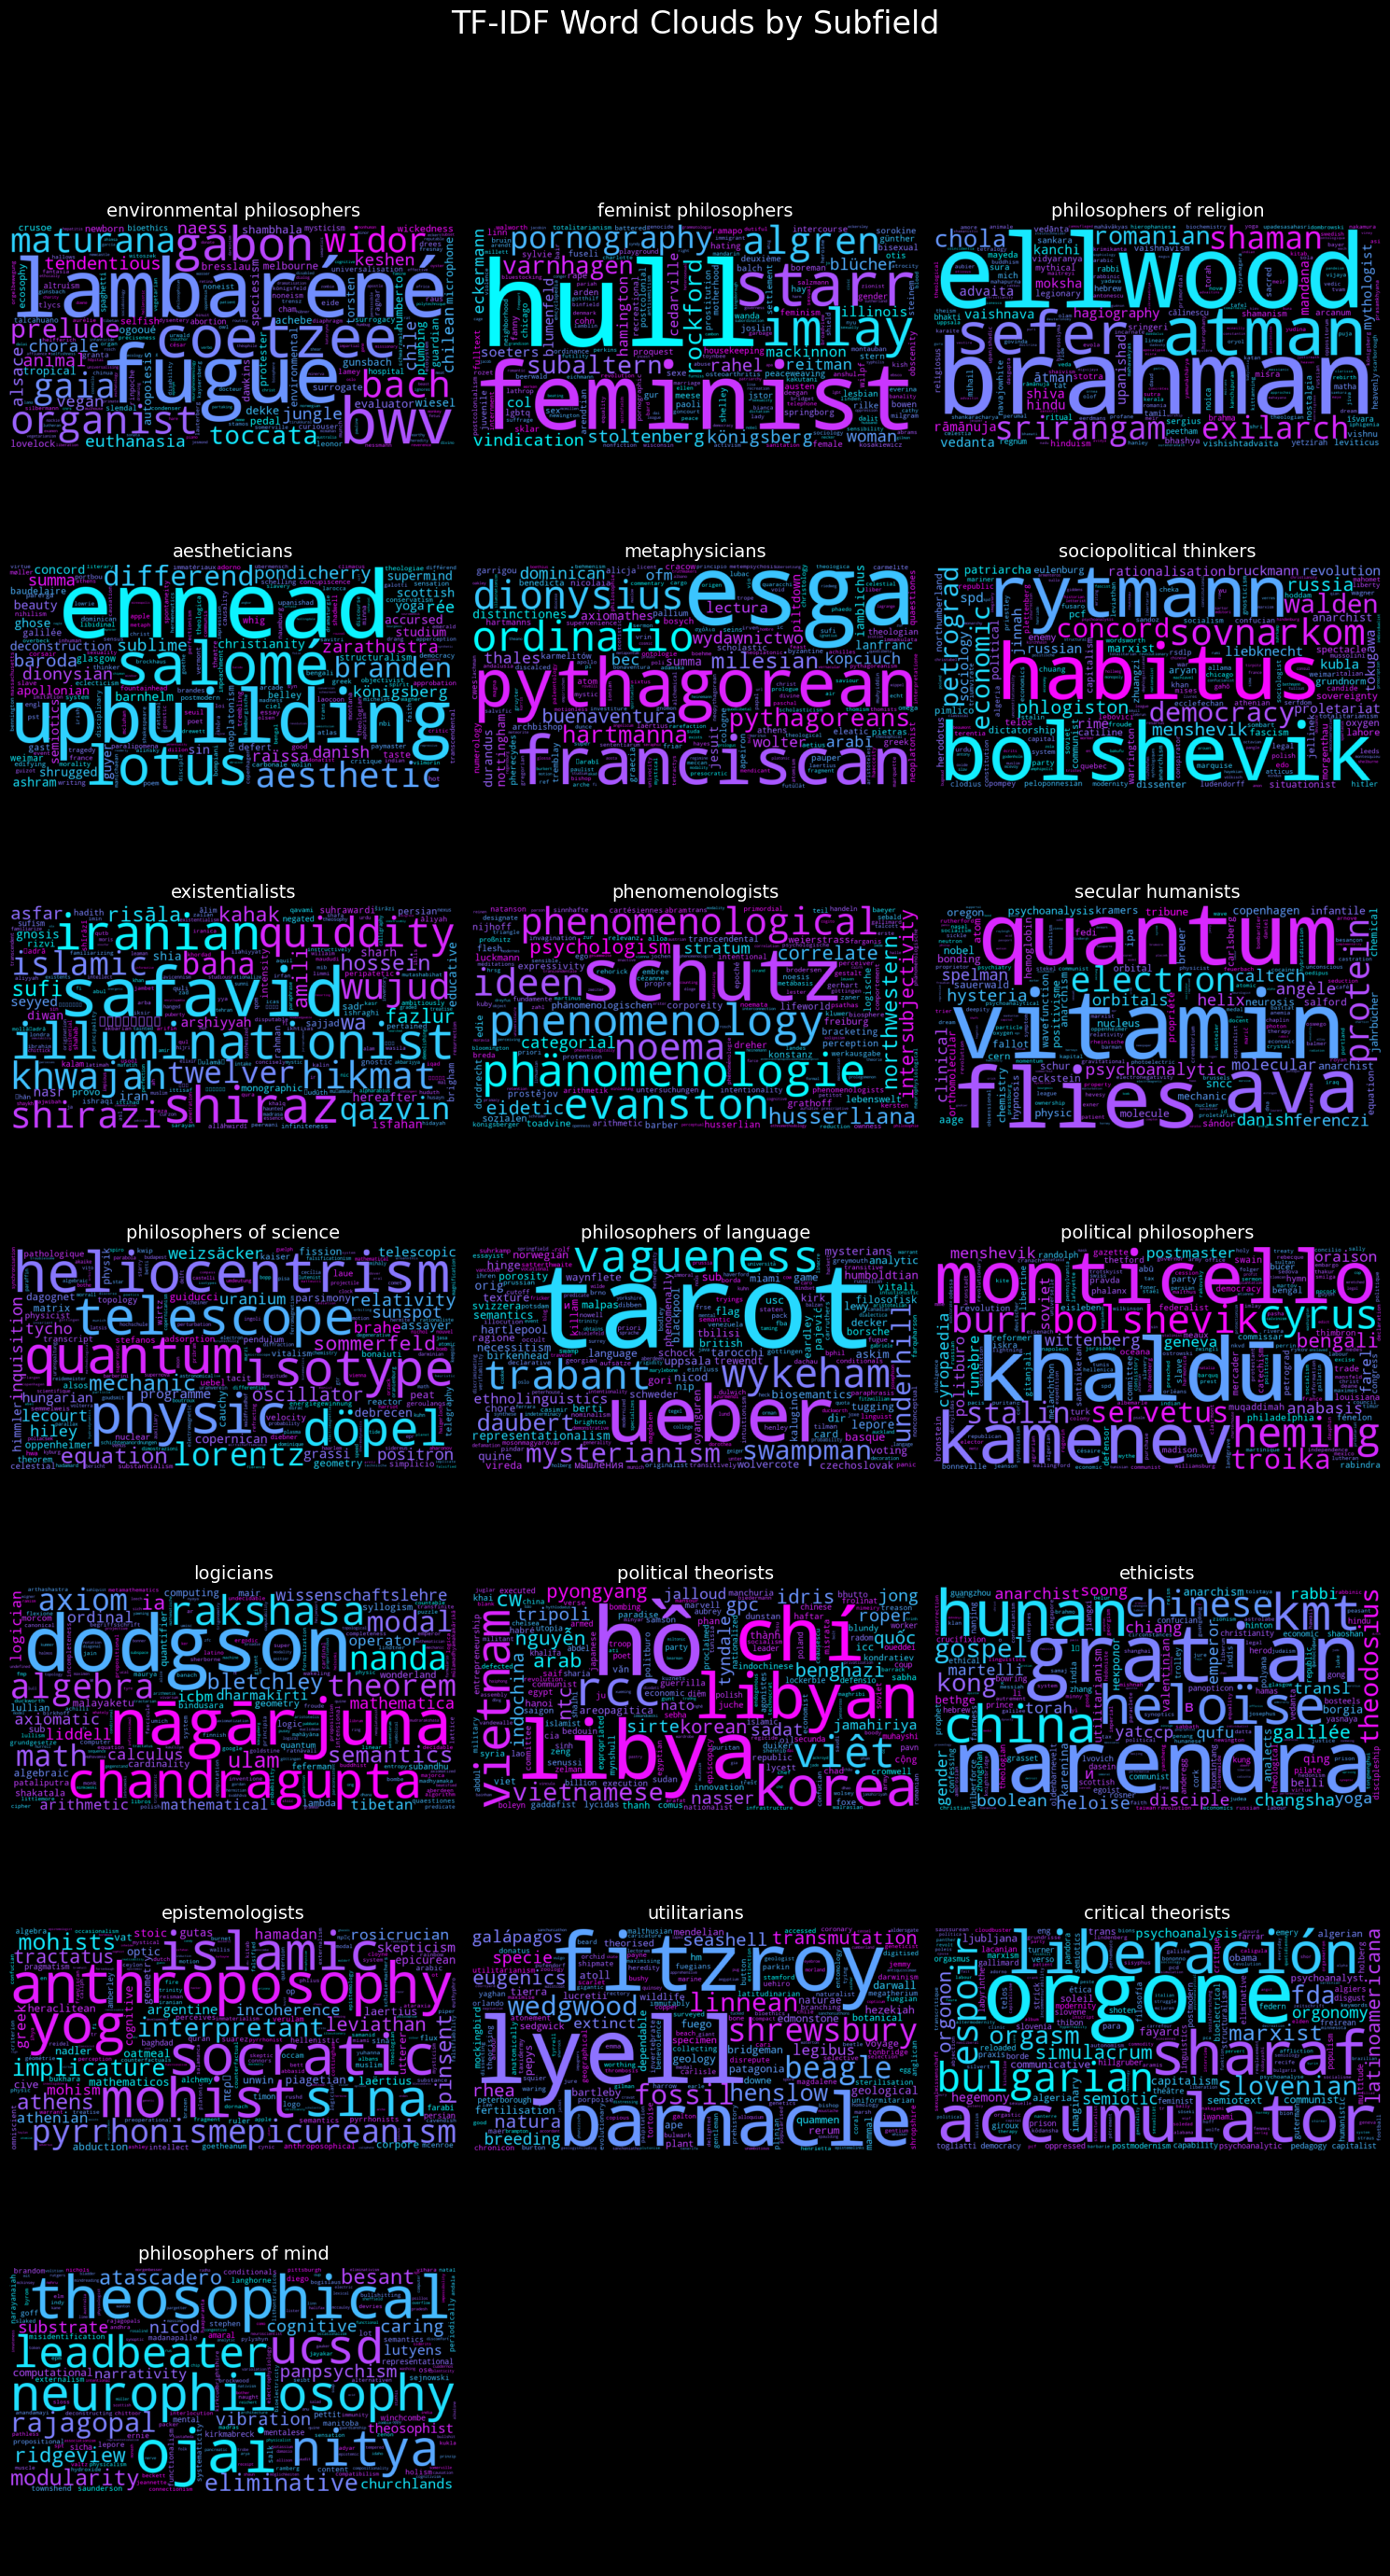

In [28]:
# Define the number of rows and columns for the subplot grid
rows, cols = 7, 3 
fig, axes = plt.subplots(rows, cols, figsize=(15, 29))
fig.patch.set_facecolor('black')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over subfields and their corresponding TF-IDF scores
for i, (subfield, tf_idf) in enumerate(tf_idf_scores.items()):
    # Stop after filling up the grid
    if i >= rows * cols:
        break

    # Create the word cloud object
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap="cool",
        contour_width=2,
        contour_color='blue',
        collocations=False,
    ).generate_from_frequencies(tf_idf)

    # Display the word cloud in the subplot
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"{subfield}", fontsize=14, color='white')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("TF-IDF Word Clouds by Subfield", fontsize=24, color='white')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


### Word Clouds by `tradition`

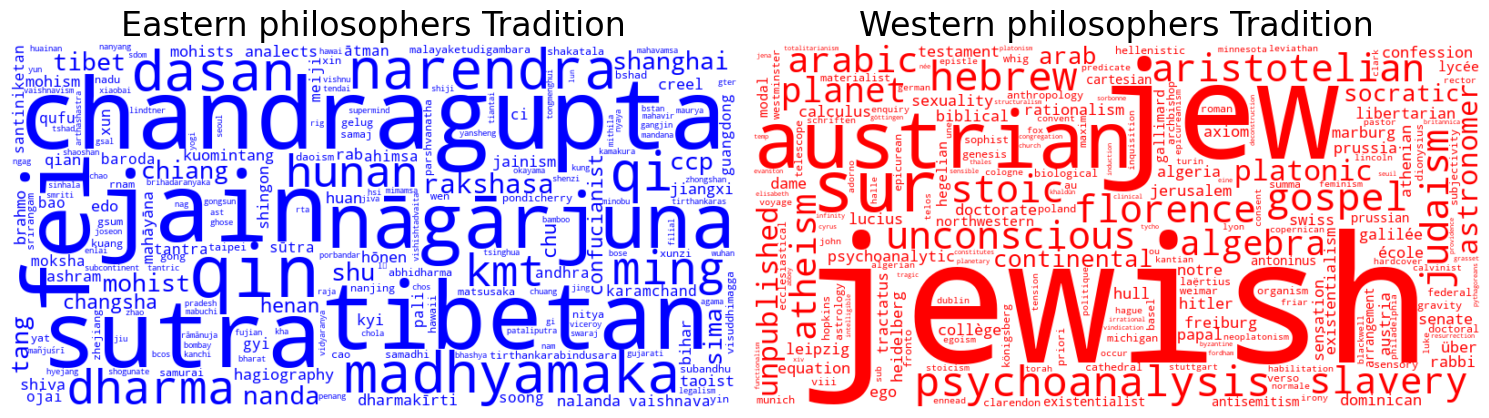

In [29]:
# Create a 1x2 grid for the word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns
fig.patch.set_facecolor('white')

# Define titles and TF-IDF data for each tradition
traditions = list(tf_idf_scores_traditions.keys())[::-1] # Reverse the order
tfidf_data = [tf_idf_scores_traditions[tradition] for tradition in traditions]

text_colors = ["blue", "red"]

# Generate and display word clouds
for ax, tradition, tf_idf, color in zip(axes, traditions, tfidf_data, text_colors):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=None,
        color_func=lambda *args, **kwargs: color,  # Force text color
        contour_width=2,
        contour_color='black',
        collocations=False
    ).generate_from_frequencies(tf_idf)
    
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{tradition} Tradition", fontsize=24, color="black")

# Add a title for the entire figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Word Clouds using the *Louvain partitions*

Compiled and cleaned text for 10 Louvain communities.


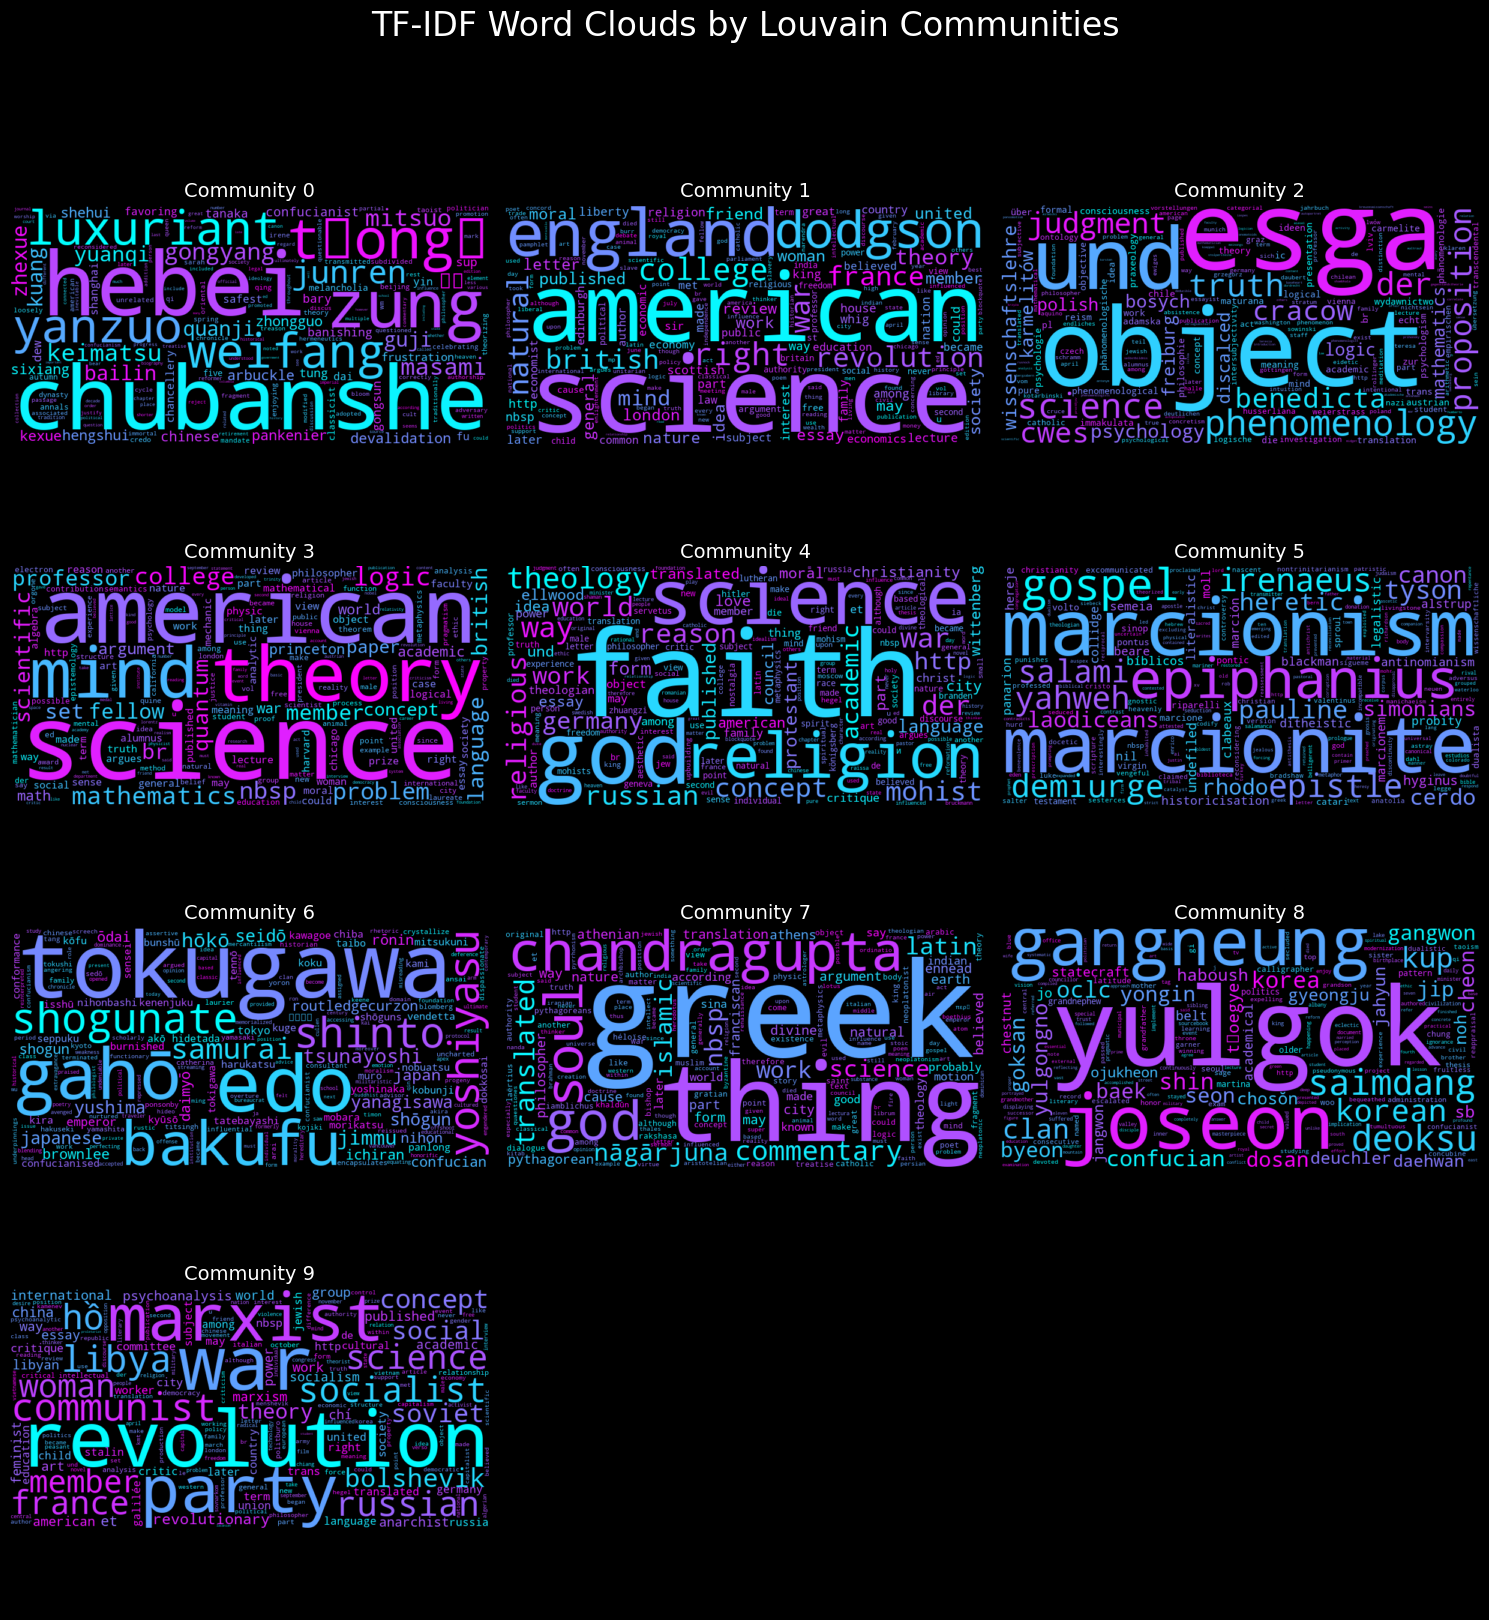

In [30]:
louvain_partition_subfields = pickle.load(open(PICKLE_DIR + "/louvain_partition_subfields.pkl", "rb"))

louvain_subfield_texts = compile_and_clean_all_subfields(louvain_partition_subfields, DOWNLOADS_DIR)
print(f"Compiled and cleaned text for {len(louvain_subfield_texts)} Louvain communities.")

# Process text and count word frequencies for all Louvain communities
word_counts_by_louvain_subfield = {}

for community, text in louvain_subfield_texts.items():
    word_counts_by_louvain_subfield[community] = process_text(text, stop_words, lemmatizer, excluded_words)

# Compute TF-IDF for all Louvain communities
tf_idf_scores_louvain = compute_tf_idf(word_counts_by_louvain_subfield)

# Define the number of rows and columns for the subplot grid
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 17))
fig.patch.set_facecolor('black')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over Louvain communities and their corresponding TF-IDF scores
for i, (community, tf_idf) in enumerate(tf_idf_scores_louvain.items()):
    # Stop after filling up the grid
    if i >= rows * cols:
        break

    # Create the word cloud object
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap="cool",
        contour_width=2,
        contour_color='blue',
        collocations=False,
    ).generate_from_frequencies(tf_idf)

    # Display the word cloud in the subplot
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Community {community}", fontsize=14, color='white')

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("TF-IDF Word Clouds by Louvain Communities", fontsize=24, color='white')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Compiled and cleaned text for 8 Louvain tradition communities.


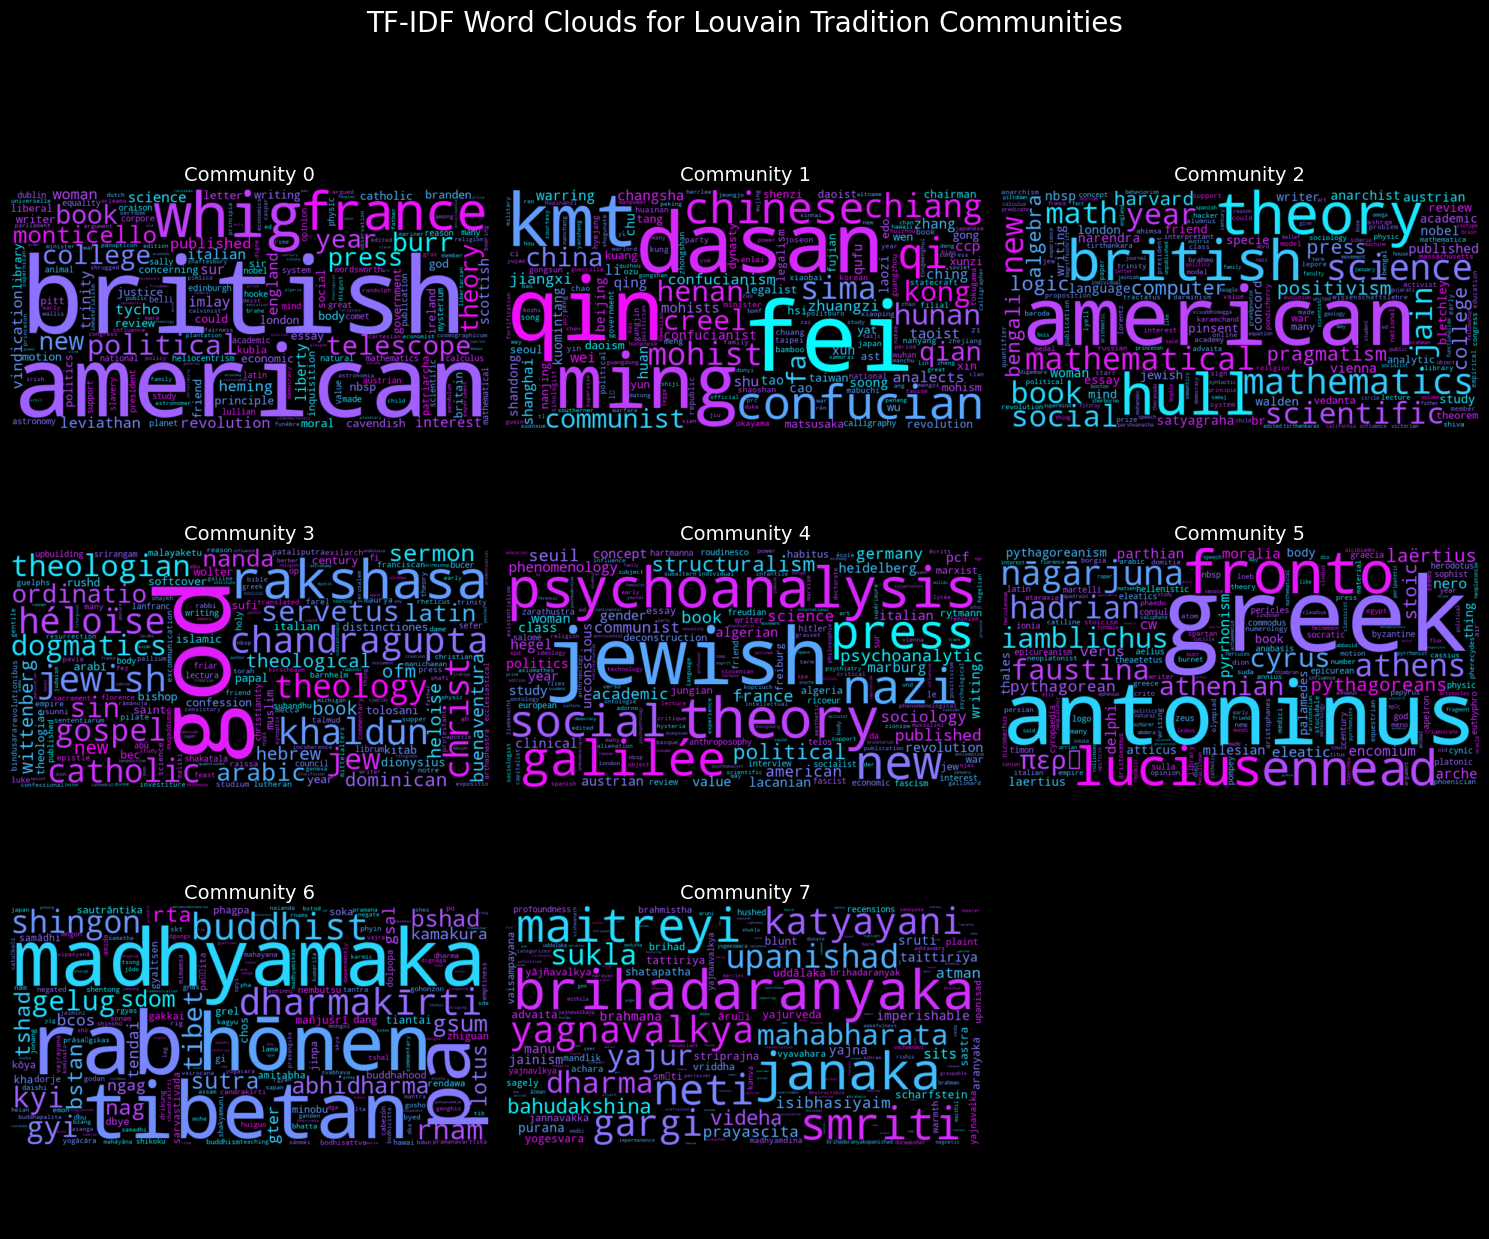

In [31]:
louvain_partition_tradition = pickle.load(open(PICKLE_DIR + "/louvain_partition_tradition.pkl", "rb"))

louvain_tradition_texts = compile_and_clean_all_subfields(louvain_partition_tradition, DOWNLOADS_DIR)
print(f"Compiled and cleaned text for {len(louvain_tradition_texts)} Louvain tradition communities.")

word_counts_by_louvain_tradition = {}

for community, text in louvain_tradition_texts.items():
    word_counts_by_louvain_tradition[community] = process_text(text, stop_words, lemmatizer, excluded_words)

tf_idf_scores_louvain_tradition = compute_tf_idf(word_counts_by_louvain_tradition)

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 13))
fig.patch.set_facecolor('black')

axes = axes.flatten()

for i, (community, tf_idf) in enumerate(tf_idf_scores_louvain_tradition.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap="cool",
        contour_width=2,
        contour_color='blue',
        collocations=False,
    ).generate_from_frequencies(tf_idf)

    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Community {community}", fontsize=14, color='white')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("TF-IDF Word Clouds for Louvain Tradition Communities", fontsize=20, color='white')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Sentiment Analysis

In [32]:
import urllib.request
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils_globals import *
from utils_sentiment_tfidf import *
from collections import Counter

# Load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

In [33]:
# Download the LabMT wordlist (with happiness scores)
file_id = "1fEW8gxKEfwiNRgpeqQ1S9qbATyrNftoE"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
local_filename = "labmt_wordlist.txt"
urllib.request.urlretrieve(url, local_filename)

('labmt_wordlist.txt', <http.client.HTTPMessage at 0x237e7820c90>)

In [34]:
# Load the LabMT wordlist into memory
labmt_wordlist = load_labmt_wordlist(local_filename)

In [35]:
process_graph(S_undirected, labmt_wordlist)

# What the nodes look like now
print(list(S_undirected.nodes(data=True))[256])


Total artists processed: 1362 out of 1362
('Henry_of_Harclay', {'contentlength': 1932, 'sentiment': 5.382159590043887})


## Some statistics

In [36]:
# Collect all valid sentiment scores from the graph
sentiment_scores = [
    S_undirected.nodes[node]["sentiment"]
    for node in S_undirected.nodes
    if S_undirected.nodes[node]["sentiment"] is not None
]

# Calculate key statistics
mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Print the statistics
print(f"Mean: {mean_sentiment:.2f}")
print(f"Median: {median_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
print(f"25th Percentile: {percentile_25:.2f}")
print(f"75th Percentile: {percentile_75:.2f}")

Mean: 5.42
Median: 5.41
Variance: 0.01
25th Percentile: 5.37
75th Percentile: 5.46


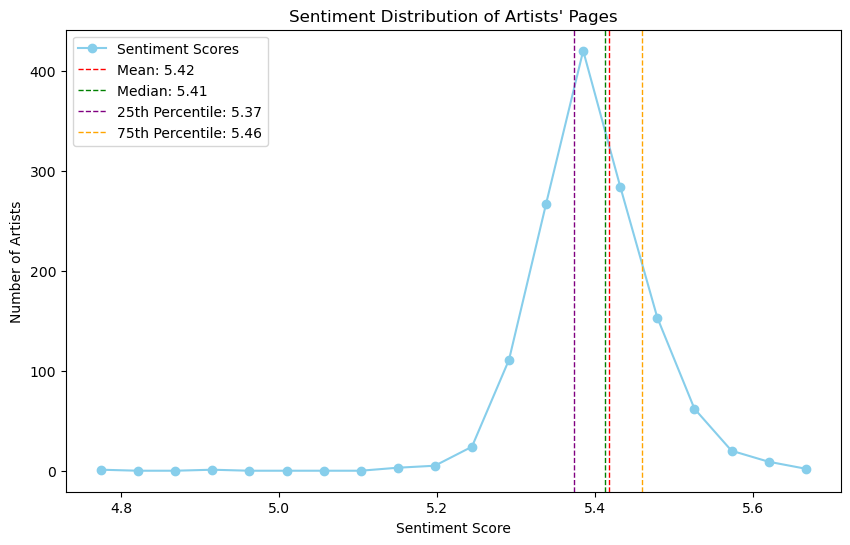

In [37]:
# A graph to represent the distribution of sentiment scores
bins = np.linspace(min(sentiment_scores), max(sentiment_scores), 21)  # 20 bins
hist_values, bin_edges = np.histogram(sentiment_scores, bins=bins)

plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist_values, marker='o', color='skyblue', linestyle='-', label="Sentiment Scores")

plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_sentiment:.2f}")
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median_sentiment:.2f}")
plt.axvline(percentile_25, color='purple', linestyle='dashed', linewidth=1, label=f"25th Percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1, label=f"75th Percentile: {percentile_75:.2f}")

plt.xlabel("Sentiment Score")
plt.ylabel("Number of Artists")
plt.title("Sentiment Distribution of Artists' Pages")
plt.legend()
plt.show()

In [38]:
# Sort nodes by sentiment score to find happiest and saddest philosophers
sorted_sentiment = sorted(
    [(node, S_undirected.nodes[node]["sentiment"]) for node in S_undirected.nodes if S_undirected.nodes[node]["sentiment"] is not None],
    key=lambda x: x[1],
    reverse=True
)

# Get the top 4 happiest and saddest philosophers
happiest_philosophes = sorted_sentiment[:4]
saddest_philosophers = sorted_sentiment[-4:]

# Print the results
print("Top 4 Happiest Philosophers:")
for artist, score in happiest_philosophes:
    print(f"{artist}: {score:.2f}")

print("\nTop 4 Saddest Philosophers:")
for artist, score in saddest_philosophers:
    print(f"{artist}: {score:.2f}")

Top 4 Happiest Philosophers:
Ram_Gopal_Varma: 5.71
Richard_Schacht: 5.68
Hartry_Field: 5.65
Annette_Baier: 5.65

Top 4 Saddest Philosophers:
Hervaeus_Natalis: 5.19
Heinrich_Rickert: 5.17
Dietrich_of_Freiberg: 4.94
Stanislaw_Lesniewski: 4.78


## Community sentiment analysis

In [39]:
# Load the subfields partitions
subfields_partition = pickle.load(open(PICKLE_DIR + "/subfields_partition.pkl", "rb"))
tradition_partition = pickle.load(open(PICKLE_DIR + "/louvain_partition_subfields.pkl", "rb"))

# Load the tradition partitions
tradition_partition = pickle.load(open(PICKLE_DIR + "/tradition_partition.pkl", "rb"))
louvain_partition_tradition = pickle.load(open(PICKLE_DIR + "/louvain_partition_tradition.pkl", "rb"))

In [40]:
# For the partition based on SUBFIELDS
# Identify the 10 largest communities by size for focused analysis
community_sizes = Counter(subfields_partition.values())
print(community_sizes)
largest_communities1 = [community for community, _ in community_sizes.most_common(10)]
print("The 10 largest communities are:", largest_communities1)

# Calculate sentiment for each of the 10 largest communities
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_community_sentiments = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

print("\nCommunities sorted by average sentiment:")
for community_id, avg_sentiment in sorted_community_sentiments:
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({'ethicists': 77, 'logicians': 72, 'metaphysicians': 68, 'epistemologists': 66, 'sociopolitical thinkers': 57, 'aestheticians': 51, 'critical theorists': 38, 'political philosophers': 30, 'philosophers of language': 25, 'philosophers of science': 18, 'philosophers of religion': 18, 'philosophers of mind': 17, 'feminist philosophers': 16, 'secular humanists': 14, 'political theorists': 8, 'utilitarians': 7, 'phenomenologists': 6, 'environmental philosophers': 6, 'existentialists': 1})
The 10 largest communities are: ['ethicists', 'logicians', 'metaphysicians', 'epistemologists', 'sociopolitical thinkers', 'aestheticians', 'critical theorists', 'political philosophers', 'philosophers of language', 'philosophers of science']

Communities sorted by average sentiment:
Community philosophers of language: Avg Sentiment = 5.492
Community philosophers of science: Avg Sentiment = 5.444
Community critical theorists: Avg Sentiment = 5.438
Community aestheticians: Avg Sentiment = 5.435
Comm

In [41]:
# For the partition based on TRADITION
# Identify the communities
community_sizes = Counter(tradition_partition.values())
print(community_sizes)
largest_communities2 = [community for community, _ in community_sizes.most_common(3)]
print("The communities are:", largest_communities2)

# Calculate sentiment for each of the communities
community_sentiments = {}
for community_id in largest_communities2:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, tradition_partition)
    community_sentiments[community_id] = avg_sentiment
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({'Western philosophers': 278, 'Eastern philosophers': 68})
The communities are: ['Western philosophers', 'Eastern philosophers']
Community Western philosophers: Avg Sentiment = 5.412
Community Eastern philosophers: Avg Sentiment = 5.415


We can also identify the **three most connected nodes** (philosophers) in each community of the partition based on the subfields.

In [42]:
community_sizes = Counter(subfields_partition.values())  
largest_communities = [community for community, _ in community_sizes.most_common(10)]

# Find top 3 connected characters for each of the 10 largest communities
top_philosophers_per_community = {}
for community_id in largest_communities:
    top_philosophers = get_top_connected_characters(S_undirected, community_id, subfields_partition)
    top_philosophers_per_community[community_id] = top_philosophers
    print(f"Community {community_id}: Top 3 characters = {top_philosophers}")

Community ethicists: Top 3 characters = ['Martin_Heidegger', 'John_Stuart_Mill', 'Adam_Smith']
Community logicians: Top 3 characters = ['Gottlob_Frege', 'Simplicius_of_Cilicia', 'Alfred_North_Whitehead']
Community metaphysicians: Top 3 characters = ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']
Community epistemologists: Top 3 characters = ['René_Descartes', 'John_Locke', 'Ludwig_Wittgenstein']
Community sociopolitical thinkers: Top 3 characters = ['Cicero', 'Voltaire', 'Louis_Althusser']
Community aestheticians: Top 3 characters = ['Aristotle', 'Immanuel_Kant', 'Plato']
Community critical theorists: Top 3 characters = ['Jürgen_Habermas', 'Paul_Feyerabend', 'Henri_Lefebvre']
Community political philosophers: Top 3 characters = ['Martin_Luther', 'Leon_Trotsky', 'Thomas_Jefferson']
Community philosophers of language: Top 3 characters = ['Gilbert_Ryle', 'Donald_Davidson_(philosopher)', 'Michael_Dummett']
Community philosophers of science: Top 3 characters = ['Galileo_Galilei', 'Ernst_Mach

**Top three** happiest and saddest communities.

In [43]:
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_communities = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

# Identify the top 3 happiest and saddest communities
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]

print("\nHappiest Communities:")
for community_id, sentiment in happiest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top philosophers: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")

print("\nSaddest Communities:")
for community_id, sentiment in saddest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top characters: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")


Happiest Communities:
Community philosophers of language (Top philosophers: ['Gilbert_Ryle', 'Donald_Davidson_(philosopher)', 'Michael_Dummett']): Avg Sentiment = 5.49
Community philosophers of science (Top philosophers: ['Galileo_Galilei', 'Ernst_Mach', 'Gaston_Bachelard']): Avg Sentiment = 5.44
Community critical theorists (Top philosophers: ['Jürgen_Habermas', 'Paul_Feyerabend', 'Henri_Lefebvre']): Avg Sentiment = 5.44

Saddest Communities:
Community political philosophers (Top characters: ['Martin_Luther', 'Leon_Trotsky', 'Thomas_Jefferson']): Avg Sentiment = 5.40
Community metaphysicians (Top characters: ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']): Avg Sentiment = 5.40
Community sociopolitical thinkers (Top characters: ['Cicero', 'Voltaire', 'Louis_Althusser']): Avg Sentiment = 5.40


Finally a **graph** to compare the average sentiment.

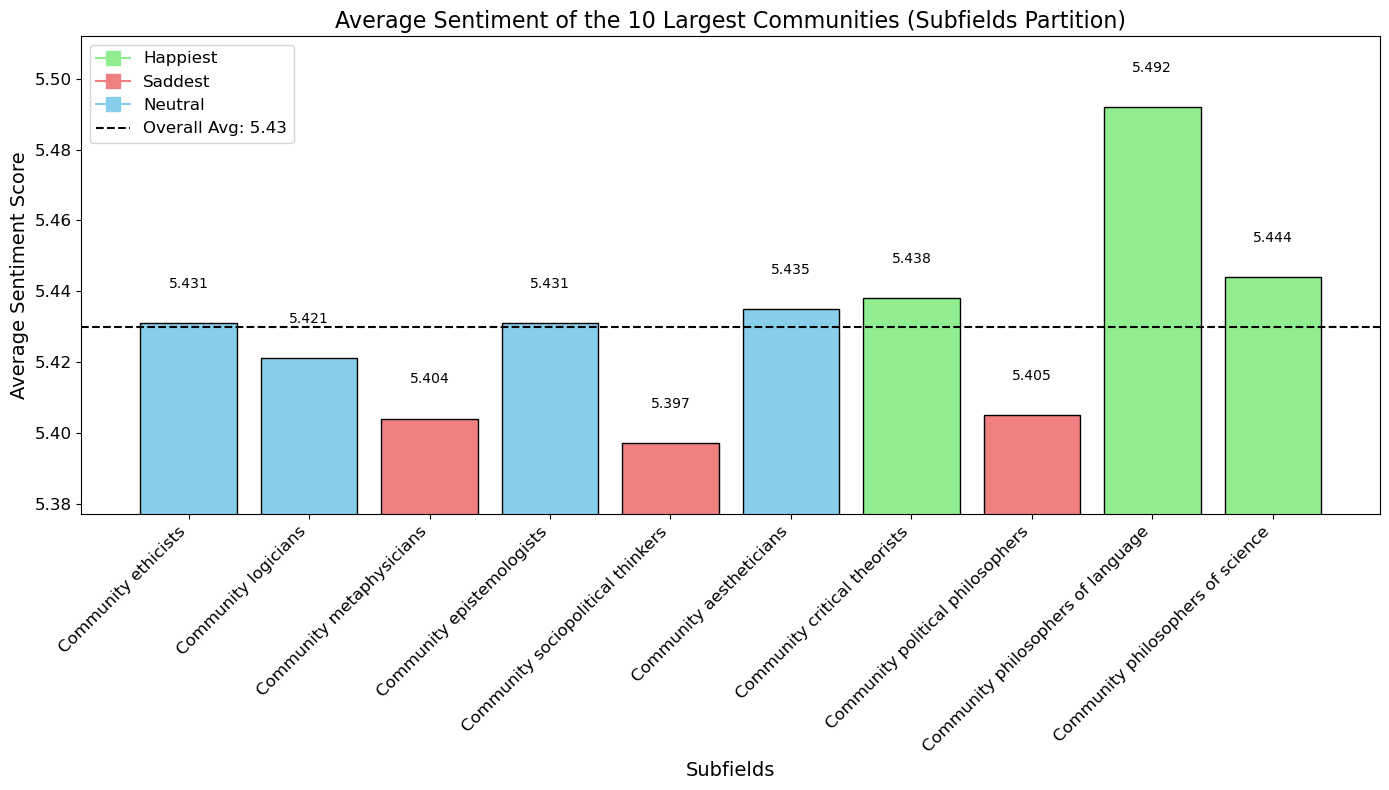

In [45]:
# Round average sentiments to two decimal places
average_sentiments = [round(community_sentiments[c], 3) for c in largest_communities]

# Prepare data for plotting
community_ids = [f"Community {c}" for c in largest_communities]

# Assign colors based on sentiment
colors = []
for community_id in largest_communities:
    if community_id in [c[0] for c in happiest_communities]:
        colors.append('lightgreen')  # Happiest communities in green
    elif community_id in [c[0] for c in saddest_communities]:
        colors.append('lightcoral')  # Saddest communities in red
    else:
        colors.append('skyblue')  # Neutral color for other communities

# Compute the average sentiment line across all communities
overall_average_sentiment = np.mean(average_sentiments)

# Create a bar plot
plt.figure(figsize=(14, 8))  # Adjust figure size for better visibility

# Plot the bars with color-coded bars for happiest and saddest communities
bars = plt.bar(community_ids, average_sentiments, color=colors, edgecolor='black', label='Average Sentiment')

# Annotate bars with rounded sentiment values
for bar, sentiment in zip(bars, average_sentiments):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{sentiment:.3f}", ha='center', fontsize=10)

# Add the overall average sentiment line
plt.axhline(y=overall_average_sentiment, color='black', linestyle='--', linewidth=1.5, label=f'Overall Avg: {overall_average_sentiment:.2f}')

# Adjust the y-axis to focus on differences
plt.ylim(min(average_sentiments) - 0.02, max(average_sentiments) + 0.02)

# Label the axes and add a title
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Subfields", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.title("Average Sentiment of the 10 Largest Communities (Subfields Partition)", fontsize=16)

# Add legend for color-coded bars and average sentiment
handles = [
    plt.Line2D([0], [0], color='lightgreen', marker='s', markersize=10, label='Happiest'),
    plt.Line2D([0], [0], color='lightcoral', marker='s', markersize=10, label='Saddest'),
    plt.Line2D([0], [0], color='skyblue', marker='s', markersize=10, label='Neutral'),
    plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label=f'Overall Avg: {overall_average_sentiment:.2f}'),
]
plt.legend(handles=handles, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
